In [1]:
import numpy as np
import numpy.linalg as npl
import numpy.fft as npf
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [2]:
#Import 2D delta map
#fname1 = '../data/tidal/0.043delta.dat_bicubic_LOS_cone1'
#npix=7745

fname1 = '../data/0.043proj_half_finer_xy_b.dat'
npix=12288


with open(fname1, 'rb') as f1:
        data_bin = np.fromfile(f1, dtype=np.float32, offset=4)
        den_map = np.reshape(np.float32(data_bin), [npix, npix])
        
        

<ipython-input-18-7197ac3630e2>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(den_map), vmin=2, vmax=7)


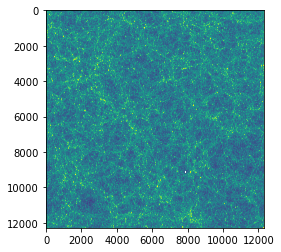

In [18]:
#Plot density field:
plt.imshow(np.log(den_map), vmin=2, vmax=7)

In [15]:
np.max(np.log(den_map))

<ipython-input-15-7c04eb0ecc75>:1: RuntimeWarning: divide by zero encountered in log
  np.max(np.log(den_map))


9.882432

In [4]:
# Adapted from Simon Samuroff's 3D-version on github

def compute_tidal_tensor(dens, smoothing=0.25, pixel_size=0.1953,box=505):
    """
    Computes the projected tidal tensor given a 2D density field
    Pixel size and smoothing scale in h^{-1} Mpc
    """
    nx = dens.shape[0]
    dfilter = False 

    norm = nx * nx 

    print('pixel scale = %3.3f'%pixel_size)
    

    k  = npf.fftfreq(nx, d=box/nx)[np.mgrid[0:nx,0:nx]]
    tidal_tensor = np.zeros((nx,nx,2,2),dtype=np.float32)
    
    if dfilter:
        sigma = smoothing/pixel_size
        print('filtering, sigma=%3.3f'%sigma)
        G = gaussian_filter(dens,sigma,mode='wrap')
    else:
        print('not filtering')
        G = dens + 1

    fft_dens = npf.fftn(G) / norm # 3D (512 x 512 x 512) grid ; each cell is a k mode
    #import pdb ; pdb.set_trace()
    for i in range(2):
        for j in range(2):
            
            # k[i], k[j] are 2D matrices, as is k
            #fft_dens = np.sqrt(fft_dens.real**2)

            temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2)

            # subtract off the trace...
            if (i==j):
                temp -= 1./2 * fft_dens

            temp[0,0] = 0

            tidal_tensor[:,:,i,j] = npf.ifftn(temp).real * norm /nx



    return tidal_tensor


In [5]:
s = compute_tidal_tensor(den_map)

pixel scale = 0.195
not filtering


<ipython-input-4-35eb8c0fdcad>:35: RuntimeWarning: invalid value encountered in true_divide
  temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2)


In [6]:
s.shape

(12288, 12288, 2, 2)

In [19]:
#plt.imshow(s[:,:,0,0]);
np.min(s[:,:,:,:])

-0.18714459

In [20]:
#plt.imshow(s[:,:,1,1]);
np.max(s[:,:,:,:])

0.18483117

In [9]:
#plt.imshow(s[:,:,1,0])

<ipython-input-24-ea054f9dce01>:5: RuntimeWarning: divide by zero encountered in log
  axs[0].imshow(np.log(den_map),vmin=2, vmax=7)


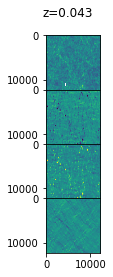

In [24]:

fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('z=0.043')
axs[0].imshow(np.log(den_map),vmin=2, vmax=7)
axs[1].imshow(s[:,:,0,0],vmin=-0.01, vmax=0.01)
axs[2].imshow(s[:,:,1,1],vmin=-0.01, vmax=0.01)
axs[3].imshow(s[:,:,1,0],vmin=-0.01, vmax=0.01)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

plt.savefig("../Plots/0.043tidal.pdf")
    
